In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_getter_and_preprocess/cleaned_train_bbox.csv')

In [3]:
ind = ["Width", "Height"]
w, h = [np.array(df[i]) for i in ind]

In [4]:
points = np.array(list(zip(w, h)))

In [5]:
len(points)

769425

In [6]:
import random

In [15]:
clusters_pos = random.sample(list(points), 6)
print(clusters_pos)

[array([0.09375 , 0.238274]), array([0.043125, 0.038033]), array([0.022642, 0.021875]), array([0.019375, 0.0475  ]), array([0.0575  , 0.245778]), array([0.92375 , 0.261667])]


In [16]:
def euclidian_dist(a, b):
    return np.linalg.norm(a - b)

In [17]:
steps = 30
for _ in tqdm(range(steps)):
    new_cluster = [[np.array([.0, .0]), 0] for _ in range(6)]
    for p in points:
        closest_clust = 0
        dist = float('inf')
        for i, c in enumerate(clusters_pos):
            tmp = euclidian_dist(p, c)
            if tmp < dist:
                dist = tmp
                closest_clust = i
        new_cluster[closest_clust][0] += p
        new_cluster[closest_clust][1] += 1
    next_clusters_pos = [nc[0] / nc[1] for nc in new_cluster]
    print("update : ", np.mean([euclidian_dist(n, a) for n, a in zip(next_clusters_pos, clusters_pos)]))
    clusters_pos = next_clusters_pos

100%|██████████| 30/30 [10:42<00:00, 21.42s/it]update :  0.0011447109620916572



seems stable enougth, let's save it

In [18]:
for c in clusters_pos:
    print(c)

[0.49667866 0.38986655]
[0.18560997 0.50520459]
[0.05772748 0.07573677]
[0.14679709 0.23791874]
[0.32449924 0.79314611]
[0.79093733 0.79929832]


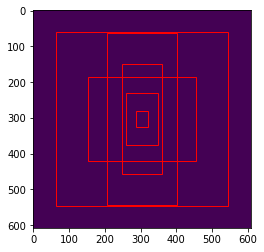

In [19]:
import matplotlib.patches as patches

imx, imy = (608, 608)

im = np.zeros((imx, imy))

fig, ax = plt.subplots()

ax.imshow(im)

for c in clusters_pos:
    # Create a Rectangle patch
    w, h = c[0] * imx, c[1] * imy
    rect = patches.Rectangle((int((imx - w) / 2), int((imy - h) / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


here are our beautifuls anchor boxes

humm.... some seems realy large, and i haven't taking into account the number of boxes for each cluster, maybe there is a LOT of little boxes and just a few big ones, let's look at this closer

In [21]:
cluster_distrib = [0] * 6
for p in points:
    closest_clust = 0
    dist = float('inf')
    for i, c in enumerate(clusters_pos):
        tmp = euclidian_dist(p, c)
        if tmp < dist:
            dist = tmp
            closest_clust = i
    cluster_distrib[closest_clust] += 1
print(cluster_distrib)

[36706, 108517, 321702, 189785, 82255, 30460]


That's what i was afraid of, let's try some tricks

In [23]:
clusters_pos = random.sample(list(points), 6)
points_len = len(points)

In [25]:
steps = 10 # reducing step number for not too perfect match
for _ in tqdm(range(steps)):
    new_cluster = [[np.array([.0, .0]), 0] for _ in range(6)]
    for p in points:
        closest_clust = 0
        dist = float('inf')
        for i, c in enumerate(clusters_pos):
            if (new_cluster[i][1] < int(points_len * 0.19)): # tricks to don't get too much point on one cluster, maybe it works ¯\_(ツ)_/¯
                tmp = euclidian_dist(p, c)
                if tmp < dist:
                    dist = tmp
                    closest_clust = i
        new_cluster[closest_clust][0] += p
        new_cluster[closest_clust][1] += 1
    next_clusters_pos = [nc[0] / nc[1] for nc in new_cluster]
    print("update : ", np.mean([euclidian_dist(n, a) for n, a in zip(next_clusters_pos, clusters_pos)]))
    clusters_pos = next_clusters_pos

100%|██████████| 10/10 [03:38<00:00, 21.82s/it]update :  0.012091737249791573



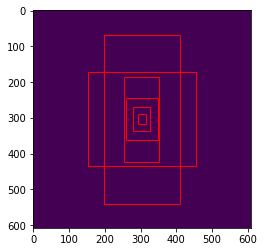

In [26]:
import matplotlib.patches as patches

imx, imy = (608, 608)

im = np.zeros((imx, imy))

fig, ax = plt.subplots()

ax.imshow(im)

for c in clusters_pos:
    # Create a Rectangle patch
    w, h = c[0] * imx, c[1] * imy
    rect = patches.Rectangle((int((imx - w) / 2), int((imy - h) / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

NICE, there is real change, let's see some numbers to see if it works

In [28]:
cluster_distrib = [0] * 6
for p in points:
    closest_clust = 0
    dist = float('inf')
    for i, c in enumerate(clusters_pos):
        tmp = euclidian_dist(p, c)
        if tmp < dist:
            dist = tmp
            closest_clust = i
    cluster_distrib[closest_clust] += 1
print(cluster_distrib)

[49904, 117639, 154627, 140632, 171627, 134996]


WOW it works, i realy love smart dirty code :P

max diff before was x10 and now it is x3

Final clusters

In [29]:
for c in clusters_pos:
    print(c)

[0.49632095 0.43112359]
[0.34734284 0.77818389]
[0.07654892 0.11315277]
[0.14702266 0.1944984 ]
[0.03598685 0.04440197]
[0.16181011 0.39138347]


In [30]:
clusters_pos = np.array(sorted(clusters_pos, key=lambda x:x[0]*x[1]))

In [31]:
for c in clusters_pos:
    print(c)

[0.03598685 0.04440197]
[0.07654892 0.11315277]
[0.14702266 0.1944984 ]
[0.16181011 0.39138347]
[0.49632095 0.43112359]
[0.34734284 0.77818389]


In [32]:
np.save("anchor_bbox", clusters_pos)